In [11]:
import geopandas as gpd
import numpy as np
import pandas as pd
from shapely.geometry import Point, Polygon
from shapely.ops import unary_union
from itertools import product

In [12]:
#rutas

ruta_poblacion =     r"C:\Users\UTIC\Documents\Alejandro\Docs\INFORME MOV\5. EMCA\Índice Ciclista\Fuentes\POBLACION.gpkg"
ruta_bicicletas =    r"C:\Users\UTIC\Documents\Alejandro\Docs\INFORME MOV\5. EMCA\Índice Ciclista\Fuentes\VIVIENDAS CON BICICLETA.gpkg"
ruta_empleos =       r"C:\Users\UTIC\Documents\Alejandro\Docs\INFORME MOV\5. EMCA\Índice Ciclista\Fuentes\EMPLEOS.gpkg"
ruta_equipamientos = r"C:\Users\UTIC\Documents\Alejandro\Docs\INFORME MOV\5. EMCA\Índice Ciclista\Índice ciclista.gpkg"
ruta_transporte =    r"C:\Users\UTIC\Documents\Alejandro\Docs\INFORME MOV\5. EMCA\Índice Ciclista\Fuentes\TRANSPORTE P MASIVO.gpkg"
ruta_mibici =        r"C:\Users\UTIC\Documents\Alejandro\Docs\INFORME MOV\5. EMCA\Índice Ciclista\Fuentes\MIBICI.gpkg"

ruta_salida = r"C:\Users\UTIC\Documents\Alejandro\Docs\INFORME MOV\5. EMCA\Índice Ciclista\Índice ciclista_py.gpkg"

In [13]:
# Cargar las capas de puntos y polígonos
manzanas_poblacion =     gpd.read_file(ruta_poblacion, layer='POBLACION')
manzanas_bicicletas =    gpd.read_file(ruta_bicicletas, layer='VIVIENDAS CON BICICLETA')
manzanas_empleos =       gpd.read_file(ruta_empleos, layer='EMPLEOS')
manzanas_equipamientos = gpd.read_file(ruta_equipamientos, layer='manzanas_cobertura_equipamientos_25k_filtrado')
paradas_transporte =     gpd.read_file(ruta_transporte, layer='TRANSPORTE P MASIVO')
estaciones_mibici =      gpd.read_file(ruta_mibici, layer='MIBICI')


In [68]:
# Definir el tamaño de la celda (en unidades del sistema de coordenadas de tus datos)
cell_size = 500  # por ejemplo, 500 metros

# Crear una grilla hexagonal o cuadrada sobre la extensión de los datos
def create_grid(gdf, cell_size, hexagonal=True):
    bounds = gdf.total_bounds
    xmin, ymin, xmax, ymax = bounds
    width = cell_size
    height = cell_size * np.sqrt(3) / 2 if hexagonal else cell_size

    cols = int(np.ceil((xmax - xmin) / width))
    rows = int(np.ceil((ymax - ymin) / height))
    
    polygons = []
    for col, row in product(range(cols), range(rows)):
        x = xmin + col * width
        y = ymin + row * height
        
        if hexagonal and col % 2 == 1:
            y += height / 2
        
        if hexagonal:
            hexagon = Polygon([
                (x, y),
                (x + width / 2, y + height / 2),
                (x + width / 2, y + 1.5 * height),
                (x, y + 2 * height),
                (x - width / 2, y + 1.5 * height),
                (x - width / 2, y + height / 2),
                (x, y)
            ])
            polygons.append(hexagon)
        else:
            square = Polygon([
                (x, y),
                (x + width, y),
                (x + width, y + height),
                (x, y + height),
                (x, y)
            ])
            polygons.append(square)
    
    return gpd.GeoDataFrame({'geometry': polygons}, crs=gdf.crs)

# Crear la grilla
grid = create_grid(manzanas_poblacion, cell_size, hexagonal=False)

In [69]:
def sum_normalized_values(grid, points, value_column):
    # Realizar la unión espacial
    joined = gpd.sjoin(points, grid, how='inner', predicate='intersects', lsuffix='left', rsuffix='right')
    
    # Agrupar por el índice del grid y sumar los valores
    grouped = joined.groupby('index_right')[value_column].sum()
    
    # Asignar los valores sumados de vuelta al grid
    grid.loc[grouped.index, value_column] = grouped
    
    # Rellenar con ceros en caso de que algunas celdas no tengan puntos
    grid[value_column] = grid[value_column].fillna(0)
    
    return grid

def count_normalized_values(grid, points, nom_col):
    # Realizar la unión espacial
    joined = gpd.sjoin(points, grid, how='inner', predicate='intersects', lsuffix='left', rsuffix='right')
    
    # Contar el número de puntos en cada celda del grid
    grouped = joined.groupby('index_right').size()
    
    # Asignar los conteos de vuelta al grid
    grid.loc[grouped.index, nom_col] = grouped
    
    # Rellenar con ceros en caso de que algunas celdas no tengan puntos
    grid[nom_col] = grid[nom_col].fillna(0)
    
    return grid

def average_equipments_values(grid,       polygons,       value_column,    nom_col):
    # Calcular los centroides
    polygons['centroid'] = polygons.geometry.centroid

    # Crear un nuevo GeoDataFrame solo con los centroides
    points = polygons.copy()
    points.set_geometry('centroid', inplace=True)

    # Realizar la unión espacial (sin repetición)
    joined = gpd.sjoin(points, grid, how='left', predicate='within', lsuffix='left', rsuffix='right')

    # Asegurarse de eliminar valores nulos antes de calcular
    joined = joined.dropna(subset=['index_right'])

    # Sumar los valores de 'VALOR EQ' y contar los puntos en cada celda del grid
    grouped = joined.groupby('index_right').agg({value_column: 'sum', 'geometry': 'count'}).rename(columns={'geometry': 'count'}).reset_index()

    # Calcular el promedio de los valores de equipamiento
    grouped[nom_col] = grouped[value_column] / grouped['count']

    # Primero, asegurarse de que 'index_right' es el índice en el grid
    grouped.set_index('index_right', inplace=True)
    
    # Asignar los valores de 'equipamientos' al grid utilizando 'index_right' como clave
    grid = grid.join(grouped[[nom_col]], how='left')
    
    # Rellenar los NaN que resulten del join
    grid[nom_col] = grid[nom_col].fillna(0)

    return grid

# Sumar valores normalizados a la grilla
grid = sum_normalized_values(grid, manzanas_poblacion, 'POBTOT')
grid = sum_normalized_values(grid, manzanas_bicicletas, 'VPH_BICI')
grid = sum_normalized_values(grid, manzanas_empleos, 'Emp_20')

grid = count_normalized_values(grid, paradas_transporte, 'transporte')
grid = count_normalized_values(grid, estaciones_mibici, 'mibici')

grid = average_equipments_values(grid, manzanas_equipamientos, 'VALOR EQ', 'equipamientos')

# Renombrar columnas para mayor claridad
grid = grid.rename(columns={
    'POBTOT': 'poblacion',
    'VPH_BICI': 'bicicletas',
    'Emp_20': 'empleos'
})

In [70]:
def normalize_columns(grid, columns):
    # Verificar y eliminar columnas duplicadas
    grid = grid.loc[:, ~grid.columns.duplicated()]
    
    for column in columns:
        if column in grid.columns:
            max_value = grid[column].max()
            if max_value != 0:  # Evitar división por cero
                norm_column = f'norm_{column}'
                grid[norm_column] = grid[column] / max_value
            else:
                grid[f'norm_{column}'] = 0
    return grid

# Lista de las columnas que deseas normalizar
columns_to_normalize = ['poblacion', 'bicicletas', 'empleos', 'transporte', 'mibici']

# Normalizar las columnas
grid = normalize_columns(grid, columns_to_normalize)

In [71]:
# Calcular el promedio ajustado
grid['in_pond'] = (
    grid['norm_bicicletas'] * 0.26 + # este valor está en cada viaje: es uno de los dos puntos de cada viaje
    grid['norm_empleos'] * 0.23 + # 54 - 68% de ocupación de ciclistas
    # grid['norm_poblacion'] * 0.2 +
    grid['equipamientos'] * 0.17 + # 13-20% de ocupación (educativo) y 2-8% de trabajos del hogar (mercados)
    grid['norm_transporte'] * 0.09 +
    grid['norm_mibici'] * 0.05
)


# Calcular el promedio ajustado
grid['inP_EMCA'] = (
    grid['norm_bicicletas'] * 0.45 +
    # grid['norm_poblacion'] * 0.05 +
    grid['norm_mibici'] * 0.1 + 
    grid['norm_empleos'] * 0.225 +
    grid['equipamientos'] * 0.16 + 
    grid['norm_transporte'] * 0.065
)

# Calcular el promedio ajustado - ORIGEN
grid['inP_EMCA_O'] = (
    grid['norm_bicicletas'] * 0.90 +
    grid['norm_mibici'] * 0.10
)

# Calcular el promedio ajustado - DESTINO
grid['inP_EMCA_D'] = (
    grid['norm_empleos'] * 0.45 +
    grid['equipamientos'] * 0.32 + 
    grid['norm_transporte'] * 0.13 +
    grid['norm_mibici'] * 0.10
)

In [72]:
# Generar centroides de cada polígono en la capa grid
grid_centroids = grid.copy()
grid_centroids['geometry'] = grid_centroids['geometry'].centroid


In [73]:
# Guardar la capa de centroides en un archivo
grid.to_file(ruta_salida, layer='grid', driver='GPKG')
grid_centroids.to_file(ruta_salida, layer='centroides', driver="GPKG")


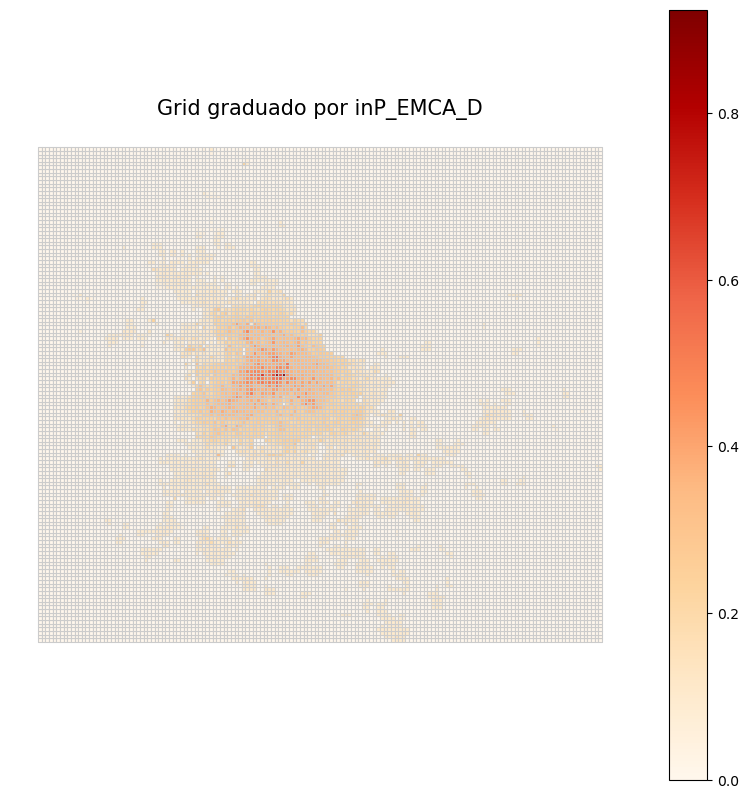

In [74]:
import geopandas as gpd
import matplotlib.pyplot as plt

def plot_grid(grid, column='inP_EMCA_D'):
    # Definir la figura y el eje
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    
    # Plotear el grid con una paleta de colores graduada según la columna 'equipamientos'
    grid.plot(column=column, cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
    
    # Añadir título
    ax.set_title(f"Grid graduado por {column}", fontsize=15)
    
    # Remover los ejes
    ax.set_axis_off()

    # Mostrar el plot
    plt.show()

# Llamar a la función con tu grid
plot_grid(grid, column='inP_EMCA_D')